# Mass Transports

Transport diagnostics for flow through major straits.

## Theory

Formally, mass transports are given by
$$T_x = \rho u  $$
$$T_y = \rho v  $$

Mass transports are diagnostics that are calculated online by the model:

|variable|long name|units|dimensions|
|-|
|tx_trans|T-cell i-mass transport|Sv|(time,st_ocean,xu_ocean,yt_ocean)|
|ty_trans|T-cell j-mass transport|Sv|(time,st_ocean,xt_ocean,yu_ocean)|


These variables are saved in `ocean.nc` files.

## Calculation

In [ ]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
# import seaborn as sns

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
cc.start_cluster()

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 35550:127.0.0.1:35550 vdi-n25.nci.org.au -l amh157


Client Scheduler: tcp://127.0.0.1:46057 Dashboard: http://127.0.0.1:35550/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [4]:
# Strait locations: [minlon, maxlon, minlat, maxlat]
# Add as many as you like, but they must be zonal or meridional

straits_01deg = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
            ('Drake Passage', [-69.9, -69.9, -71.6, -51.0]),
            ('Lombok Strait', [-244.3, -243.8, -8.37, -8.37]),
            ('Ombai Strait',  [-234.9, -234.9, -8.86, -8.27]),
            ('Timor Strait',  [-232.6, -232.6, -13.96, -8.37]),
            ('Bering Strait', [-172, -167, 65.8, 65.8]),
            ('Denmark Strait',[-42, -22, 65.8, 65.8])
            ])
straits_025deg = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
            ('Drake Passage', [-69.9, -69.9, -71.6, -51.0]),
            ('Lombok Strait', [-244.5, -243.5, -8.22, -8.22]),
            ('Ombai Strait',  [-235.5, -235.5, -9.21, -8.47]),
            ('Timor Strait',  [-233, -233, -13.86, -8.71])
            ])
straits_1deg = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
            ('Drake Passage', [-69.9, -69.9, -71.6, -51.0]),
            ('Lombok Strait', [-245, -242, -8.33, -8.33]),
            ('Ombai Strait',  [-237, -237, -10.33, -8.33]),
            ('Timor Strait',  [-233, -233, -13.9, -9])
            ])

NameError: name 'straits' is not defined

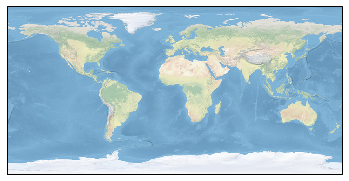

In [5]:
# TODO: plot straits on actual model bathymetry 


import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

for strait, (xmin, xmax, ymin, ymax) in straits.items():

    plt.plot([xmin, xmax], [ymin, ymax],
            color='red', linewidth=4, alpha=0.5,
             transform=ccrs.Geodetic() )
   
    plt.annotate(xy=(xmin, ymin), xycoords='data',
                 xytext=(xmax+2, ymax),
                 s=strait,
               #  arrowprops=dict(facecolor='black', shrink=0.05),
                 transform=ccrs.Geodetic(),
                clip_on=True)

#ax.set_global()
#plt.annotate(xy=(0, 0), s='origin', transform=ccrs.Geodetic())
#plt.show()


In [6]:
##@memory.cache
def calc_transport(ekey, strait):
    """
    Calculate barotropic transport across a given 
     line of latitude or longitude.
     
    Designed for flow through straits.
    """
    
    expt = exptdata.exptdict[ekey]['expt']
    n = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    print('Calculating {} {} transport'.format(expt, strait))
    print('with {} files, time units of {} and offset of  {} days'.format(n, time_units, offset))
    
    if ekey=='1deg':
        straits=straits_1deg
    if ekey=='025deg':
        straits=straits_025deg
    if ekey=='01deg':
        straits=straits_01deg
    
    xmin, xmax, ymin, ymax = straits[strait]
    
    if xmin == xmax:
        tx_trans = cc.get_nc_variable(expt, 
                                'ocean_month.nc', 
                                'tx_trans_int_z',
                                 n=n,
                                 time_units=time_units, offset=offset)
        
        transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))\
                            .sum('yt_ocean')

    elif ymin == ymax:
        ty_trans = cc.get_nc_variable(expt, 
                                      'ocean_month.nc', 
                                      'ty_trans_int_z',
                                      n=n,
                                      time_units=time_units, offset=offset)
        transport = ty_trans.sel(yu_ocean=ymin, method='nearest')\
                            .sel(xt_ocean=slice(xmin, xmax))\
                            .sum('xt_ocean')
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    
    transport = transport.compute()
       
    return transport

### A plot for Indonesian Seas only

In [11]:
%%time
itf_straits = ['Lombok Strait', 'Ombai Strait',  'Timor Strait']
results = []
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    desc = exptdata.exptdict[ekey]['desc']
    for i, strait in enumerate(itf_straits):
# convert from kg/s to Sv, assuming typical in-situ density of 1036kg/m^3
# https://www.nature.com/scitable/knowledge/library/key-physical-variables-in-the-ocean-temperature-102805293
        transport = calc_transport(ekey, strait)/1e6/1036
        transport_mean = transport.resample(time='A').mean('time')
        
        result = {'transport_mean': transport_mean,'expt': expt,'desc': desc,'i': i}
        results.append(result)

IPython.display.clear_output()

CPU times: user 3min 13s, sys: 1min 40s, total: 4min 53s
Wall time: 5min 11s


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous a

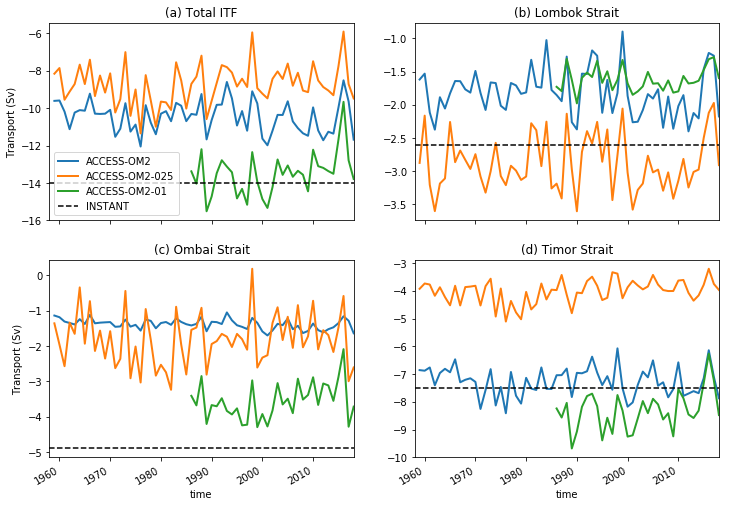

In [12]:
plt.figure(figsize=(12,8))
for result in results:
    transport_mean = result['transport_mean']
    desc = result['desc']
    i = result['i']
    
    if i==0:
        total_transport = transport_mean
    else:
        total_transport = total_transport+transport_mean
        
    plt.subplot(2, 2, i+2)
    transport_mean.plot(label=desc, linewidth=2)
    plt.ylabel('')
    plt.gca().autoscale()

    if i ==2:
        plt.subplot(221)
        total_transport.plot(label=desc, linewidth=2)
        plt.title('(a) Total ITF')
        plt.ylabel('')
        plt.gca().autoscale()

for k in range(1,i+2,2):
    plt.subplot(2, 2, k)
    plt.ylabel('Transport (Sv)')

for k in range(1,3,1):
    plt.subplot(2, 2, k)
    plt.xlabel('')
    plt.gca().axes.xaxis.set_ticklabels([])

plt.subplot(221)
plt.plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[-14, -14],'k--',label="INSTANT")
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.legend()

plt.subplot(222)
plt.plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[-2.6, -2.6],'k--',label="INSTANT")
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.title('(b) '+itf_straits[0])

plt.subplot(223)
plt.plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[-4.9, -4.9],'k--',label="INSTANT")
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.title('(c) '+itf_straits[1])

plt.subplot(224)
plt.plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[-7.5, -7.5],'k--',label="INSTANT")
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.title('(d) '+itf_straits[2])

savefigure('ITF_transport')

# Drake Passage Transport

In [13]:
%%time
strait = 'Drake Passage'
results = []
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    desc = exptdata.exptdict[ekey]['desc']
    transport = calc_transport(ekey, strait)/1e6/1036
    transport_mean = transport.resample(time='A').mean('time')
    result = {'transport_mean': transport_mean,'expt': expt,'desc': desc}
    results.append(result)

IPython.display.clear_output()
    

CPU times: user 1min 4s, sys: 31.1 s, total: 1min 35s
Wall time: 1min 40s


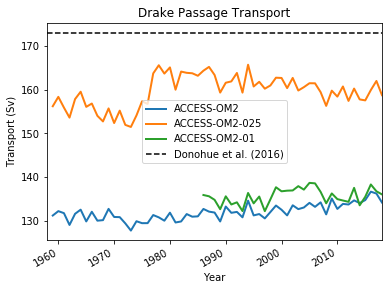

In [14]:
plt.figure(figsize=(6,4))
for result in results:
    transport_mean = result['transport_mean']
    desc = result['desc']
    transport_mean.plot(label=desc, linewidth=2)

plt.plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[173, 173],'k--',label="Donohue et al. (2016)")
plt.legend()
plt.gca().autoscale()
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.title('Drake Passage Transport')
plt.xlabel('Year')
plt.ylabel('Transport (Sv)')
savefigure('DP_transport')

**Below here, not used for manuscript**
----

In [ ]:
ncols = 2
nrows = math.ceil(len(straits)/ncols)
tstart = 1e10
tend = -1e10
# transports = copy.deepcopy(exptdata.exptdict)  # this will store speed fields under the same keys as exptdata.exptdict
plt.figure(figsize=(12,10))
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    desc = exptdata.exptdict[ekey]['desc']
    for i, strait in enumerate(straits):
# convert from kg/s to Sv, assuming typical in-situ density of 1036kg/m^3
# https://www.nature.com/scitable/knowledge/library/key-physical-variables-in-the-ocean-temperature-102805293
#        if ekey == '01deg':
#            transport = calc_transport(expt, strait,n=410)/1e6/1036
#             tstart = min(tstart, transport['time'].data[0])  # first time in model data
#             tend = max(tend, transport['time'].data[-1])  # final time in model data
#        else:
        transport = calc_transport(ekey, strait)/1e6/1036
        transport_mean = transport.resample(time='A').mean('time')
        plt.subplot(nrows, ncols, i+1)
        transport_mean.plot(label=desc+', annual mean', linewidth=2)
        #transport.plot(label=desc, linewidth=0.2, alpha=0.5)
        plt.title(strait)
        plt.ylabel('')
        plt.gca().autoscale()

for k in range(1,i+2,2):
    plt.subplot(nrows, ncols, k)
    plt.ylabel('Transport (Sv)')

for k in range(1,i,1):
    plt.subplot(nrows, ncols, k)
    plt.xlabel('')
    plt.gca().axes.xaxis.set_ticklabels([])

# for k in range(1,i+2,1):
#     plt.subplot(nrows, ncols, k)
#     plt.gca().xlim([tstart, tend])

plt.subplot(nrows, ncols, i+1)
plt.legend(bbox_to_anchor=(-0.1,-0.25), loc='upper center')

savefigure('strait_transports')

In [ ]:
ekey = '01deg'
expt = exptdata.exptdict[ekey]['expt']
n = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
ty_trans = cc.get_nc_variable(expt, 
                                'ocean_month.nc', 
                                'ty_trans_int_z',
                                 n=n,
                                 time_units=time_units, offset=offset)
        

In [ ]:
xmin, xmax, ymin, ymax = straits_01deg['Lombok Strait']

transport = ty_trans.sel(yu_ocean=ymin, method='nearest')\
                            .sel(xt_ocean=slice(xmin, xmax))
transport.isel(time=0).plot()
print(transport.mean('time').sum('xt_ocean').values)


In [ ]:
ty_trans.sel(xt_ocean=slice(xmin-1,xmax+1))\
            .sel(yu_ocean=slice(ymin-1, ymax+1)).mean('time').plot()


In [ ]:
ymin

In [ ]:
xmax